# Tracking Benchmark

This notebook performs tracking evaluation on the previously tracked and manually supervised dataset in the Aegear project. 

In [38]:
import os
import json

import gdown

import torch

import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import Rbf

from aegear.tracker import FishTracker
from aegear.video import VideoClip

In [2]:
# 1. load data
# 2. prep tracking model
# 3. run tracking and compare to the reference GT data

In [3]:
# 1. Device selection
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [4]:
dataset_dir = '../data/training'
video_dir = "../data/video"

# K9 test data
data = {
    "file": 'tracking_K9_clean.json',
    "annotation_gdrive_id": "12jLIHBySVG3G0Ie52NlmRHQ7U3Sv6ca-",
    "video_gdrive_id": "1iZMfmCJnYsIxBIXqVwRrpubO2-_uItHU"
}

# Create directories if they do not exist.
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

annotations_file = os.path.join(dataset_dir, data["file"])

# Check if each of the dataset units is present
if not os.path.exists(annotations_file):
    print("Downloading dataset...")
    gdown.download(id=data["annotation_gdrive_id"], output=annotations_file, quiet=False,fuzzy=True)

# Read the data
with open(annotations_file, 'r') as f:
    annotations = json.load(f)

video_file = os.path.join(video_dir, annotations["video"])
if not os.path.exists(video_file):
    print("Downloading video...")
    gdown.download(id=data["video_gdrive_id"], output=video_file, quiet=False, fuzzy=True)

In [ ]:
# 2. Initialize FishTracker
heatmap_model_path = "../data/models/model_efficient_unet_2025-05-11.pth"
siamese_model_path = "../data/models/model_siamese_2025-05-12.pth"

tracker = FishTracker(
    heatmap_model_path=heatmap_model_path,
    siamese_model_path=siamese_model_path,
    tracking_threshold=0.9,
    detection_threshold=0.9,
    tracking_max_skip=7,
)

In [32]:
# Load video and tracking
video = VideoClip(video_file)
gt_tracking = {item["frame_id"]: tuple(item["coordinates"]) for item in annotations["tracking"]}

In [33]:
pred_tracking = {}
def model_track_register(frame_id, centroid, confidence):
    pred_tracking[frame_id] = (centroid, confidence)
def ui_update(frame_id):
    pass  # No-op for notebook

In [ ]:
from tqdm.notebook import tqdm

class TqdmProgressReporter:
    def __init__(self, start_frame, end_frame):
        self.start_frame = start_frame
        self.end_frame = end_frame
        self.total = end_frame - start_frame
        self.pbar = tqdm(total=self.total, desc="Tracking Progress")
        self.last_frame = start_frame

    def update(self, current_frame):
        # Advance the bar by the number of frames processed since last update
        self.pbar.update(current_frame - self.last_frame)
        self.last_frame = current_frame

    def still_running(self):
        # Always True for notebook use
        return True

    def close(self):
        self.pbar.close()

In [35]:
progress_reporter = TqdmProgressReporter(min(gt_tracking.keys()), max(gt_tracking.keys()))

tracker.run_tracking(
    video,
    min(gt_tracking.keys()),
    max(gt_tracking.keys()),
    model_track_register,
    progress_reporter=progress_reporter,
    ui_update=None
)

Tracking Progress:   0%|          | 0/14390 [00:00<?, ?it/s]

KeyboardInterrupt: 

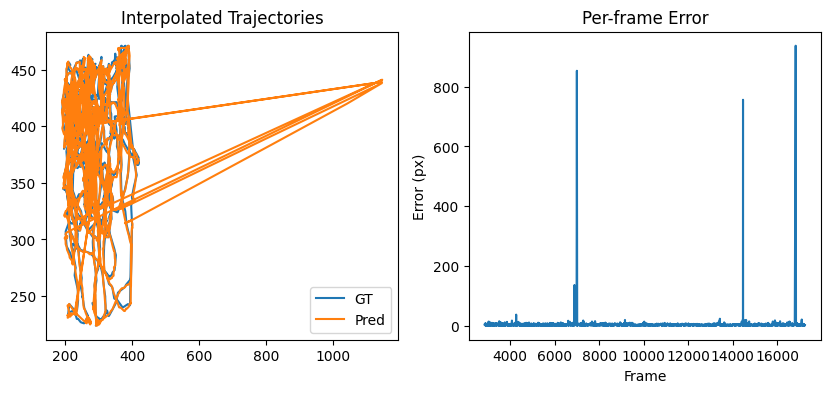

In [ ]:
# Assume gt_tracking and pred_tracking are dicts: frame_id -> (x, y)
gt_frames = np.array(sorted(gt_tracking.keys()))
gt_coords = np.array([gt_tracking[f] for f in gt_frames])

pred_frames = np.array(sorted(pred_tracking.keys()))
pred_coords = np.array([pred_tracking[f][0] for f in pred_frames])

# Fit RBF interpolators
rbf_gt_x = Rbf(gt_frames, gt_coords[:, 0], function='multiquadric', epsilon=0.5)
rbf_gt_y = Rbf(gt_frames, gt_coords[:, 1], function='multiquadric', epsilon=0.5)

rbf_pred_x = Rbf(pred_frames, pred_coords[:, 0], function='multiquadric', epsilon=0.5)
rbf_pred_y = Rbf(pred_frames, pred_coords[:, 1], function='multiquadric', epsilon=0.5)

# Evaluate on the union of all frame IDs
all_frames = np.arange(min(gt_frames.min(), pred_frames.min()), max(gt_frames.max(), pred_frames.max())+1)
gt_interp = np.stack([rbf_gt_x(all_frames), rbf_gt_y(all_frames)], axis=1)
pred_interp = np.stack([rbf_pred_x(all_frames), rbf_pred_y(all_frames)], axis=1)

# Compute per-frame error
errors = np.linalg.norm(gt_interp - pred_interp, axis=1)

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(gt_interp[:,0], gt_interp[:,1], label='GT')
plt.plot(pred_interp[:,0], pred_interp[:,1], label='Pred')
plt.legend()
plt.title("Interpolated Trajectories")

plt.subplot(1,2,2)
plt.plot(all_frames, errors)
plt.title("Per-frame Error")
plt.xlabel("Frame")
plt.ylabel("Error (px)")
plt.show()

In [ ]:
errors = np.array(errors)
print(f"Mean error: {np.nanmean(errors):.2f} px")
print(f"Median error: {np.nanmedian(errors):.2f} px")
print(f"Frames within 3px: {(errors < 3).sum() / len(errors):.2%}")
print(f"Frames within 5px: {(errors < 5).sum() / len(errors):.2%}")
print(f"False hits (>20px): {len(errors[errors > 20])}: {(errors > 20).sum() / len(errors):.2%}")


Mean error: 6.08 px
Median error: 2.77 px
Frames within 3px: 54.94%
Frames within 5px: 82.66%
False hits (>20px): 109: 0.76%


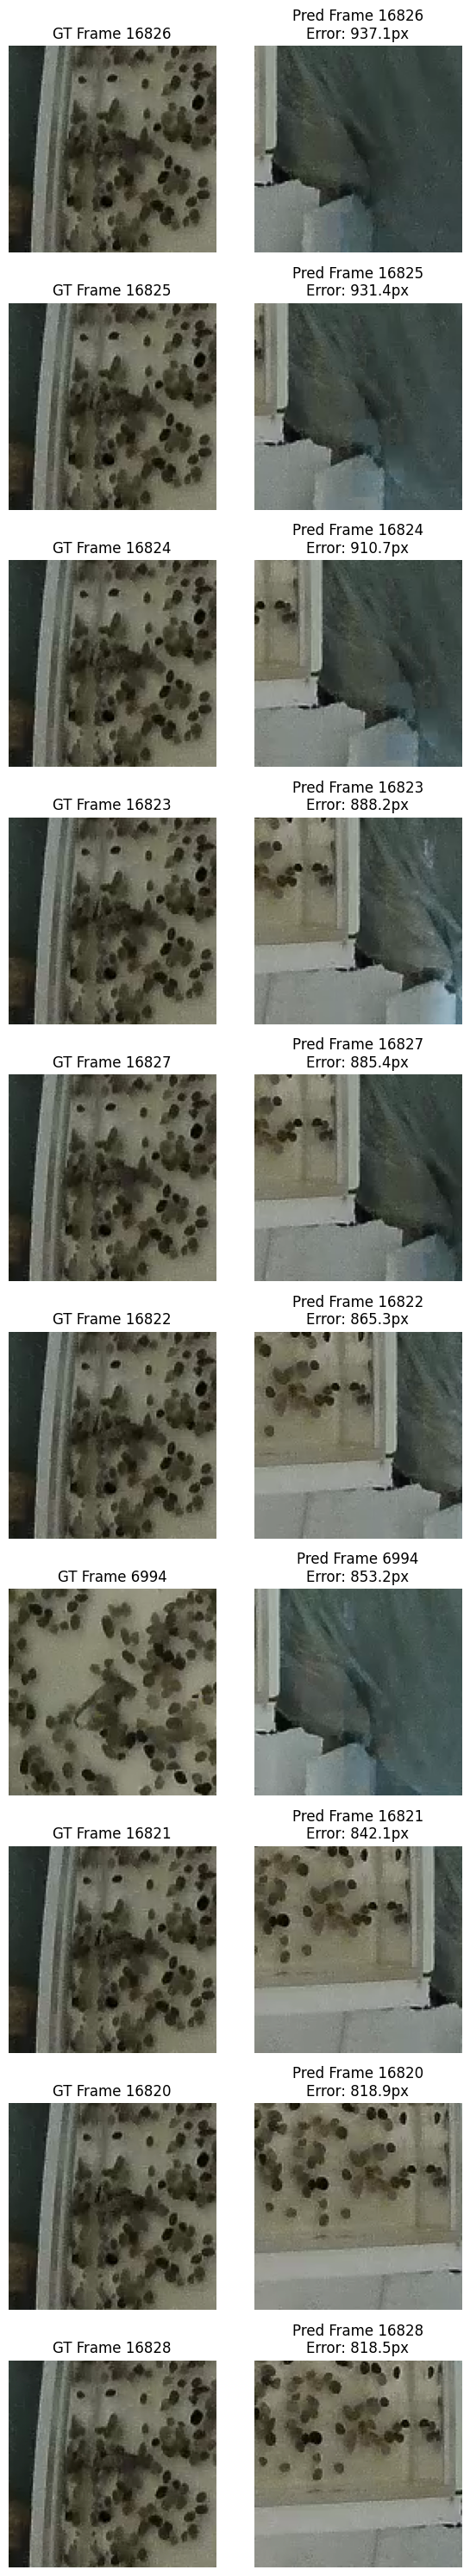

In [ ]:
N = 10  # Number of worst cases to show
crop_size = 128

# Find indices of the N largest errors
worst_indices = np.argsort(errors)[-N:][::-1]
worst_frames = all_frames[worst_indices]

fig, axes = plt.subplots(N, 2, figsize=(6, 3*N))
for i, frame_id in enumerate(worst_frames):
    frame = video.get_frame(float(frame_id) / video.fps)
    if frame is None:
        continue

    # GT crop
    gt_xy = gt_interp[worst_indices[i]]
    gt_x, gt_y = int(gt_xy[0]), int(gt_xy[1])
    gt_crop = frame[
        max(gt_y-crop_size//2,0):gt_y+crop_size//2,
        max(gt_x-crop_size//2,0):gt_x+crop_size//2
    ]

    # Pred crop
    pred_xy = pred_interp[worst_indices[i]]
    pred_x, pred_y = int(pred_xy[0]), int(pred_xy[1])
    pred_crop = frame[
        max(pred_y-crop_size//2,0):pred_y+crop_size//2,
        max(pred_x-crop_size//2,0):pred_x+crop_size//2
    ]

    # Plot
    axes[i, 0].imshow(gt_crop, cmap='gray')
    axes[i, 0].set_title(f"GT Frame {frame_id}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(pred_crop, cmap='gray')
    axes[i, 1].set_title(f"Pred Frame {frame_id}\nError: {errors[worst_indices[i]]:.1f}px")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

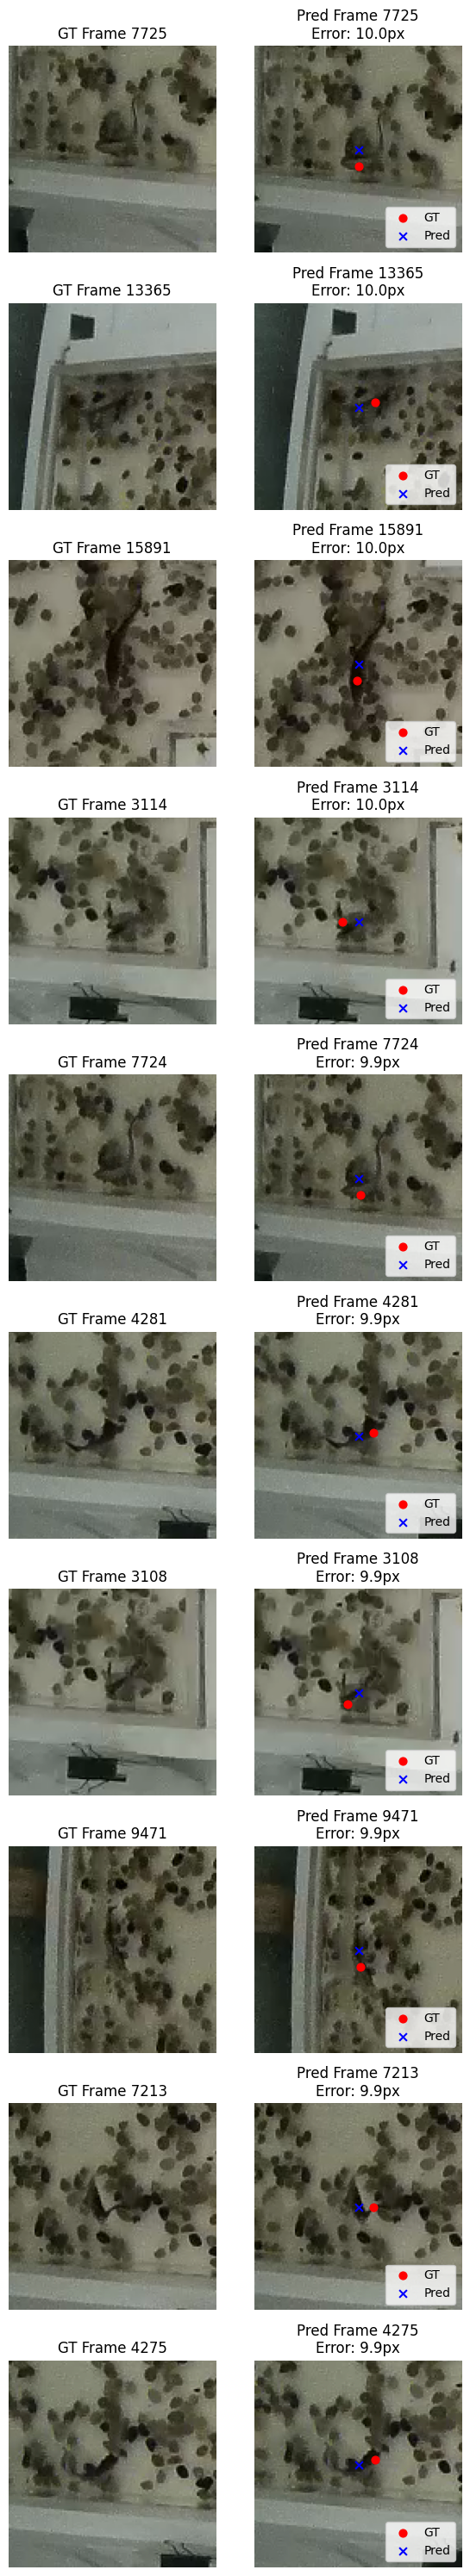

In [41]:
N = 10  # Number of cases to show
crop_size = 128

# Find indices where error is between 5 and 10 pixels
mid_error_mask = (errors > 5) & (errors <= 10)
mid_error_indices = np.where(mid_error_mask)[0]

# If there are more than N, take the N largest errors in this range
if len(mid_error_indices) > N:
    selected = mid_error_indices[np.argsort(errors[mid_error_indices])[-N:][::-1]]
else:
    selected = mid_error_indices

selected_frames = all_frames[selected]

fig, axes = plt.subplots(len(selected), 2, figsize=(6, 3*len(selected)))
if len(selected) == 1:
    axes = np.expand_dims(axes, axis=0)  # Ensure axes is 2D

for i, frame_id in enumerate(selected_frames):
    frame = video.get_frame(float(frame_id) / video.fps)
    if frame is None:
        continue

    # GT and Pred coordinates
    gt_xy = gt_interp[selected[i]]
    pred_xy = pred_interp[selected[i]]
    gt_x, gt_y = int(gt_xy[0]), int(gt_xy[1])
    pred_x, pred_y = int(pred_xy[0]), int(pred_xy[1])

    # GT crop (for reference, unchanged)
    gt_crop = frame[
        max(gt_y-crop_size//2,0):gt_y+crop_size//2,
        max(gt_x-crop_size//2,0):gt_x+crop_size//2
    ]

    # Pred crop
    pred_crop = frame[
        max(pred_y-crop_size//2,0):pred_y+crop_size//2,
        max(pred_x-crop_size//2,0):pred_x+crop_size//2
    ]

    # Calculate relative positions in the pred crop
    rel_gt_x = (gt_x - (pred_x - crop_size//2))
    rel_gt_y = (gt_y - (pred_y - crop_size//2))
    rel_pred_x = crop_size // 2
    rel_pred_y = crop_size // 2

    # Plot GT crop
    axes[i, 0].imshow(gt_crop, cmap='gray')
    axes[i, 0].set_title(f"GT Frame {frame_id}")
    axes[i, 0].axis('off')

    # Plot Pred crop with centroids
    axes[i, 1].imshow(pred_crop, cmap='gray')
    axes[i, 1].scatter([rel_gt_x], [rel_gt_y], c='r', marker='o', label='GT', s=40)
    axes[i, 1].scatter([rel_pred_x], [rel_pred_y], c='b', marker='x', label='Pred', s=40)
    axes[i, 1].set_title(f"Pred Frame {frame_id}\nError: {errors[selected[i]]:.1f}px")
    axes[i, 1].axis('off')
    axes[i, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()